In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, List, Tuple, Dict


class IEKF:
    """
    Iterated Extended Kalman Filter.

    Parameters:
    -----------
    f, F_jac: state transition function and Jacobian
    h, H_jac: measurement function and Jacobian
    Q, R: process and measurement noise covariances
    x0, P0: initial state and covariance
    max_iter: maximum iterations for update step
    convergence_tol: convergence tolerance for iterations
    state_constraints: optional function to enforce state limits
    """

    def __init__(
        self,
        f: Callable[[np.ndarray], np.ndarray],
        F_jac: Callable[[np.ndarray], np.ndarray],
        h: Callable[[np.ndarray], np.ndarray],
        H_jac: Callable[[np.ndarray], np.ndarray],
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: np.ndarray,
        max_iter: int = 5,
        convergence_tol: float = 1e-6,
        state_constraints: Optional[
            Callable[[np.ndarray], np.ndarray]
        ] = None,
    ):
        assert Q.shape == (len(x0), len(x0)), "Q dimension mismatch"
        assert P0.shape == (len(x0), len(x0)), "P0 dimension mismatch"

        self.f = f
        self.F_jac = F_jac
        self.h = h
        self.H_jac = H_jac
        self.Q = Q.copy()
        self.R = R.copy()
        self.max_iter = max_iter
        self.convergence_tol = convergence_tol
        self.state_constraints = state_constraints

        self.x = x0.copy()
        self.P = P0.copy()

        # Histories
        self.state_history: List[np.ndarray] = [self.x.copy()]
        self.cov_history: List[np.ndarray] = [self.P.copy()]
        self.innovations: List[np.ndarray] = []  # Predicted innovations
        self.innovation_covariances: List[np.ndarray] = []  # Predicted S
        self._innovations_filt: List[np.ndarray] = []  # Post-update innovations
        self._innov_cov_filt: List[np.ndarray] = []  # Post-update S
        self.convergence_history: List[Dict[str, object]] = []

    def predict(self) -> Tuple[np.ndarray, np.ndarray]:
        x_pred = self.f(self.x)
        if self.state_constraints:
            x_pred = self.state_constraints(x_pred)

        F = self.F_jac(self.x)
        P_pred = F @ self.P @ F.T + self.Q
        # Enforce symmetry
        P_pred = 0.5 * (P_pred + P_pred.T)

        self.x, self.P = x_pred, P_pred
        return self.x.copy(), self.P.copy()

    def update(self, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        x_pred = self.x.copy()
        P_pred = self.P.copy()
        x_i = x_pred.copy()

        converged = False
        iterations = 0
        S_pred = None

        # Iterated update
        for k in range(self.max_iter):
            iterations = k + 1
            H = self.H_jac(x_i)
            h_val = self.h(x_i)

            # Innovation for iteration
            y = z - h_val + H @ (x_i - x_pred)

            S_pred = H @ P_pred @ H.T + self.R
            S_pred = 0.5 * (S_pred + S_pred.T) + 1e-9 * np.eye(S_pred.shape[0])

            try:
                K = P_pred @ H.T @ np.linalg.inv(S_pred)
            except np.linalg.LinAlgError:
                K = P_pred @ H.T @ np.linalg.pinv(S_pred)

            x_new = x_pred + K @ y
            if self.state_constraints:
                x_new = self.state_constraints(x_new)

            if np.linalg.norm(x_new - x_i) < self.convergence_tol:
                x_i = x_new
                converged = True
                break
            x_i = x_new

        # Record convergence info
        self.convergence_history.append({
            'converged': converged,
            'iterations': iterations,
        })

        # Final linearization at x_i
        Hf = self.H_jac(x_i)
        S_f = Hf @ P_pred @ Hf.T + self.R
        S_f = 0.5 * (S_f + S_f.T) + 1e-9 * np.eye(S_f.shape[0])
        try:
            K_f = P_pred @ Hf.T @ np.linalg.inv(S_f)
        except np.linalg.LinAlgError:
            K_f = P_pred @ Hf.T @ np.linalg.pinv(S_f)

        # Covariance update
        I_KH = np.eye(len(x_i)) - K_f @ Hf
        P_upd = I_KH @ P_pred @ I_KH.T + K_f @ self.R @ K_f.T
        P_upd = 0.5 * (P_upd + P_upd.T)

        # Store states
        self.x = x_i
        self.P = P_upd
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())

        # Store predicted innovation and covariance
        innov_pred = z - self.h(x_pred)
        self.innovations.append(innov_pred)
        self.innovation_covariances.append(S_pred)

        # Store post-update innovation and covariance
        innov_filt = z - self.h(self.x)
        self._innovations_filt.append(innov_filt)
        self._innov_cov_filt.append(S_f)

        return self.x.copy(), self.P.copy()

    def run_sequence(
        self, measurements: np.ndarray, steps_per_meas: int
    ) -> np.ndarray:
        """
        Run predict steps_per_meas times, then update(z),
        for each measurement z in measurements. Returns filtered
        states (dropping the initial guess).
        """
        for z in measurements:
            for _ in range(steps_per_meas):
                self.predict()
            self.update(z)
        return np.array(self.state_history)[1:]

    def get_nis(self, method: str = 'predicted') -> Optional[float]:
        """
        Compute average Normalized Innovation Squared (NIS) across updates.

        method: 'predicted' uses innovation = z - h(x_pred) and S_pred,
                'filtered' uses innovation = z - h(x_filt) and S_f.
        """
        if method == 'predicted':
            inn_list = self.innovations
            S_list = self.innovation_covariances
        elif method == 'filtered':
            inn_list = self._innovations_filt
            S_list = self._innov_cov_filt
        else:
            raise ValueError("method must be 'predicted' or 'filtered'")

        if not inn_list:
            return None

        nis_vals = []
        for inn, S in zip(inn_list, S_list):
            try:
                nis_vals.append(float(inn.T @ np.linalg.inv(S) @ inn))
            except np.linalg.LinAlgError:
                continue

        return float(np.mean(nis_vals)) if nis_vals else None

In [2]:
class GolfBallPhysics:
    """
    Golf ball physics: quadratic drag plus Magnus effect plus spin decay.
    """

    def __init__(self, dt: float = 0.01):
        self.dt = dt
        self.m = 0.04593
        self.r = 0.02135
        self.A = np.pi * self.r**2
        self.g = 9.81
        self.rho = 1.225
        self.Cd = 0.25
        self.Cl = 0.2

    def state_transition(self, x: np.ndarray) -> np.ndarray:
        pos = x[0:3]
        vel = x[3:6]
        spin = x[6:9]

        v_mag = max(np.linalg.norm(vel), 1e-10)
        Fd = -0.5 * self.rho * self.Cd * self.A * v_mag * vel
        Fm = 0.5 * self.rho * self.Cl * self.A * np.cross(spin, vel)

        a = (Fd + Fm) / self.m
        a[2] -= self.g

        new_pos = pos + self.dt * vel
        new_vel = vel + self.dt * a
        new_spin = spin * (1.0 - 0.001 * self.dt)

        return np.hstack([new_pos, new_vel, new_spin])

    def state_jacobian(self, x: np.ndarray) -> np.ndarray:
        n = len(x)
        F = np.eye(n)
        F[0:3, 3:6] = self.dt * np.eye(3)

        if n >= 6:
            vel = x[3:6]
            v_mag = max(np.linalg.norm(vel), 1e-10)
            drag_c = -0.5 * self.rho * self.Cd * self.A / self.m * self.dt
            for i in range(3):
                for j in range(3):
                    F[3 + i, 3 + j] += drag_c * (
                        v_mag * (i == j) + vel[i] * vel[j] / v_mag
                    )
            if n == 9:
                spin = x[6:9]
                magnus_c = 0.5 * self.rho * self.Cl * self.A / self.m * self.dt
                # Partial derivative of (omega cross v) wrt v
                F[3, 4] += -magnus_c * spin[2]
                F[3, 5] += magnus_c * spin[1]
                F[4, 3] += magnus_c * spin[2]
                F[4, 5] += -magnus_c * spin[0]
                F[5, 3] += -magnus_c * spin[1]
                F[5, 4] += magnus_c * spin[0]
                # Partial derivative of (omega cross v) wrt omega
                F[3, 7] += magnus_c * vel[2]
                F[3, 8] += -magnus_c * vel[1]
                F[4, 6] += -magnus_c * vel[2]
                F[4, 8] += magnus_c * vel[0]
                F[5, 6] += magnus_c * vel[1]
                F[5, 7] += -magnus_c * vel[0]
                # Spin decay
                F[6:9, 6:9] *= (1.0 - 0.001 * self.dt)
        return F

In [3]:
class GolfSensorSystem:
    """
    Fuse radar (range, radial vel) and two cameras (az, el) to 6D measurement.
    """

    def __init__(
        self,
        radar_pos: Optional[np.ndarray] = None,
        camera_positions: Optional[List[np.ndarray]] = None,
    ):
        self.radar_pos = (
            radar_pos if radar_pos is not None
            else np.array([0.0, -5.0, 2.0])
        )
        self.camera_positions = (
            camera_positions if camera_positions is not None
            else [
                np.array([-10.0, -5.0, 5.0]),
                np.array([10.0, -5.0, 5.0]),
            ]
        )
        self.radar_range_std = 0.5
        self.radar_velocity_std = 0.5
        self.camera_angle_std = 0.002

    def radar_measurement(
        self, x: np.ndarray, add_noise: bool = True
    ) -> np.ndarray:
        pos = x[0:3]
        vel = x[3:6]
        r_vec = pos - self.radar_pos
        r_mag = max(np.linalg.norm(r_vec), 1e-10)
        r_hat = r_vec / r_mag
        v_rad = float(np.dot(vel, r_hat))
        meas = np.array([r_mag, v_rad])
        if add_noise:
            meas += np.random.normal(
                loc=[0.0, 0.0],
                scale=[self.radar_range_std, self.radar_velocity_std],
            )
        return meas

    def camera_measurement(
        self, x: np.ndarray, camera_idx: int = 0, add_noise: bool = True
    ) -> np.ndarray:
        pos = x[0:3]
        cam = self.camera_positions[camera_idx]
        r = pos - cam
        r_xy2 = max(r[0]**2 + r[1]**2, 1e-10)
        az = float(np.arctan2(r[1], r[0]))
        el = float(np.arctan2(r[2], np.sqrt(r_xy2)))
        meas = np.array([az, el])
        if add_noise:
            meas += np.random.normal(
                loc=0.0,
                scale=self.camera_angle_std,
                size=2,
            )
        return meas

    def fused_measurement(
        self, x: np.ndarray, add_noise: bool = True
    ) -> np.ndarray:
        return np.hstack([
            self.radar_measurement(x, add_noise),
            self.camera_measurement(x, 0, add_noise),
            self.camera_measurement(x, 1, add_noise),
        ])

    def measurement_function(self, x: np.ndarray) -> np.ndarray:
        return self.fused_measurement(x, add_noise=False)

    def measurement_jacobian(self, x: np.ndarray) -> np.ndarray:
        n = len(x)
        H = np.zeros((6, n))
        pos = x[0:3]
        vel = x[3:6]

        # Range
        r_vec = pos - self.radar_pos
        r_mag = max(np.linalg.norm(r_vec), 1e-10)
        H[0, :3] = r_vec / r_mag

        # Radial velocity
        H[1, 3:6] = r_vec / r_mag
        H[1, :3] = (
            vel - np.dot(vel, r_vec / r_mag) * (r_vec / r_mag)
        ) / r_mag

        # Cameras
        for i, cam in enumerate(self.camera_positions):
            r = pos - cam
            r_xy2 = max(r[0]**2 + r[1]**2, 1e-10)
            r_xy = np.sqrt(r_xy2)
            az_i = 2 + 2 * i
            el_i = az_i + 1

            H[az_i, 0] = -r[1] / r_xy2
            H[az_i, 1] = r[0] / r_xy2

            r_mag2 = max(r_xy2 + r[2]**2, 1e-10)
            H[el_i, 0] = -r[2] * r[0] / (r_xy * r_mag2)
            H[el_i, 1] = -r[2] * r[1] / (r_xy * r_mag2)
            H[el_i, 2] = r_xy / r_mag2

        return H

In [4]:
def golf_ball_constraints(x: np.ndarray) -> np.ndarray:
    """
    Keep altitude >= 0, clip velocity and spin to physical limits.
    """
    y = x.copy()
    y[2] = max(0.0, y[2])  # Ground
    v = y[3:6]
    if np.linalg.norm(v) > 100.0:
        y[3:6] = v * 100.0 / np.linalg.norm(v)
    if len(y) >= 9:
        spin = y[6:9]
        max_spin = 300 * 2 * np.pi
        if np.linalg.norm(spin) > max_spin:
            y[6:9] = spin * max_spin / np.linalg.norm(spin)
    return y

In [5]:
def simulate_golf_shot(
    physics: GolfBallPhysics,
    sensors: GolfSensorSystem,
    initial_speed: float = 70,
    launch_angle: float = 12,
    backspin_rpm: float = 2500,
    sidespin_rpm: float = 300,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate true 9D state trajectory and 6D noisy measurements.
    """
    theta = np.deg2rad(launch_angle)
    back = backspin_rpm * 2 * np.pi / 60
    side = sidespin_rpm * 2 * np.pi / 60
    vx = initial_speed * np.cos(theta)
    vz = initial_speed * np.sin(theta)

    x0 = np.array([
        0.0,
        0.0,
        0.1,
        vx,
        0.0,
        vz,
        side,
        -back,
        0.0,
    ])
    traj: List[np.ndarray] = [x0.copy()]
    meas: List[np.ndarray] = []

    dt_meas = 0.05
    t = 0.0
    max_t = 10.0
    while traj[-1][2] >= 0 and t < max_t:
        for _ in range(int(dt_meas / physics.dt)):
            traj.append(physics.state_transition(traj[-1]))
        if traj[-1][2] >= 0:
            meas.append(
                sensors.fused_measurement(traj[-1], add_noise=True)
            )
        t += dt_meas

    return np.array(traj), np.array(meas)

In [6]:
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.mean((a - b) ** 2)))


def position_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    return rmse(truth[:, :3], est[:, :3])


def velocity_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    return rmse(truth[:, 3:6], est[:, 3:6])


def spin_error(true_rpm: np.ndarray, est_rpm: np.ndarray) -> float:
    return float(np.mean(np.abs(true_rpm - est_rpm)))


def landing_error(t: np.ndarray, e: np.ndarray) -> float:
    return float(np.linalg.norm(t[:2] - e[:2]))

In [7]:
def plot_trajectory(
    true_traj: np.ndarray,
    est_trajs: List[np.ndarray],
    labels: List[str],
    sample: int = 5,
    title: Optional[str] = None,
) -> None:
    """
    Plot 3D trajectory of true and estimated states.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    idx = slice(0, None, sample)

    ax.plot(
        true_traj[idx, 0],
        true_traj[idx, 1],
        true_traj[idx, 2],
        '--k',
        lw=3,
        label=labels[0],
    )
    colors = ['b', 'r', 'g', 'm', 'c']
    for i, (traj, lbl) in enumerate(zip(est_trajs, labels[1:])):
        ax.plot(
            traj[idx, 0],
            traj[idx, 1],
            traj[idx, 2],
            '-',
            color=colors[i],
            lw=2,
            marker='o',
            markevery=10,
            markersize=4,
            alpha=0.8,
            label=lbl,
        )

    ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_error(
    t: np.ndarray,
    errors: List[np.ndarray],
    labels: List[str],
    ylabel: str,
    title: Optional[str] = None,
    logscale: bool = False,
) -> None:
    """
    Plot error metrics over time.
    """
    plt.figure(figsize=(8, 5))
    for err, lbl in zip(errors, labels):
        if logscale:
            plt.semilogy(t, err, lw=2, label=lbl)
        else:
            plt.plot(t, err, lw=2, label=lbl)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_convergence_analysis(
    hist: List[Dict[str, object]],
) -> None:
    """
    Plot IEKF iteration counts and convergence flags.
    """
    iters = [h['iterations'] for h in hist]
    conv = [h['converged'] for h in hist]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    ax1.plot(iters, '-b', lw=2)
    ax1.set(title='IEKF Iterations', ylabel='Iterations')
    ax1.grid(alpha=0.3)

    ax2.scatter(
        range(len(conv)),
        conv,
        c=conv,
        cmap='RdYlGn',
        s=50,
    )
    ax2.set(xlabel='Update #', ylabel='Converged')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['No', 'Yes'])
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
def plot_innovation_analysis(
    innovations: List[np.ndarray],
    covariances: List[np.ndarray],
) -> None:
    """
    Plot innovation values with 3-sigma covariance bounds.
    """
    inn = np.array(innovations)
    n_meas = inn.shape[1]
    fig, axes = plt.subplots(n_meas, 1, figsize=(8, 2 * n_meas))
    names = ['Range', 'RadVel', 'Az1', 'El1', 'Az2', 'El2']

    for i, ax in enumerate(axes):
        ax.plot(inn[:, i], '-b', lw=1)
        sigma3 = 3 * np.sqrt([C[i, i] for C in covariances])
        ax.fill_between(range(len(inn)), -sigma3, sigma3, alpha=0.2)
        ax.set_ylabel(names[i])
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Update #')
    fig.suptitle('Innovation Analysis')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [11]:
class BallTrackingDemo:
    """
    Orchestrates simulation, IEKF filtering, metrics, and plotting
    for a golf ball ballistic tracking demo.
    """

    def __init__(
        self,
        physics: GolfBallPhysics,
        sensors: GolfSensorSystem,
        initial_speed: float = 70,
        launch_angle: float = 12,
        backspin_rpm: float = 2500,
        sidespin_rpm: float = 300,
        dt_meas: float = 0.05,
    ):
        self.physics = physics
        self.sensors = sensors
        self.initial_speed = initial_speed
        self.launch_angle = launch_angle
        self.backspin_rpm = backspin_rpm
        self.sidespin_rpm = sidespin_rpm
        self.dt_meas = dt_meas

    def run(self) -> None:
        # Simulate
        traj, meas = simulate_golf_shot(
            self.physics,
            self.sensors,
            self.initial_speed,
            self.launch_angle,
            self.backspin_rpm,
            self.sidespin_rpm,
        )
        print(f"Simulated {len(traj)} states, {len(meas)} measurements")

        # Init filter
        x0_true = traj[0]
        x0_guess = x0_true.copy()
        x0_guess[3:6] *= 0.9
        x0_guess[6:9] = [
            0,
            -1000 * 2 * np.pi / 60,
            0,
        ]

        P0 = np.diag([0.1] * 3 + [5] * 3 + [10] * 3)
        Q = np.diag([0.001] * 3 + [0.01] * 3 + [0.1] * 3)
        R = np.diag([
            self.sensors.radar_range_std**2,
            self.sensors.radar_velocity_std**2,
            *(
                self.sensors.camera_angle_std**2
                for _ in range(4)
            ),
        ])

        filter_ = IEKF(
            f=self.physics.state_transition,
            F_jac=self.physics.state_jacobian,
            h=self.sensors.measurement_function,
            H_jac=self.sensors.measurement_jacobian,
            Q=Q,
            R=R,
            x0=x0_guess,
            P0=P0,
            state_constraints=golf_ball_constraints,
        )

        steps = int(self.dt_meas / self.physics.dt)

        # Run filter
        est_states = filter_.run_sequence(meas, steps)

        # Align truth and estimates
        truth_meas = traj[::steps]
        n = min(len(truth_meas), len(est_states))
        truth = truth_meas[:n]
        est = est_states[:n]
        time = np.arange(n) * self.dt_meas

        # Metrics
        pos_err = position_rmse(truth, est)
        vel_err = velocity_rmse(truth, est)
        true_spin = -truth[:, 7] * 60 / (2 * np.pi)
        est_spin = -est[:, 7] * 60 / (2 * np.pi)
        spin_err_val = spin_error(true_spin, est_spin)

        t_idx = np.where(truth[:, 2] <= 0)[0]
        e_idx = np.where(est[:, 2] <= 0)[0]
        land_err = (
            landing_error(truth[t_idx[0]], est[e_idx[0]])
            if t_idx.size and e_idx.size else None
        )

        avg_it = float(
            np.mean([h['iterations'] for h in filter_.convergence_history])
        )
        conv_rt = float(
            np.mean([h['converged'] for h in filter_.convergence_history])
        )
        nis_pred = filter_.get_nis('predicted')
        nis_filt = filter_.get_nis('filtered')

        # Print metrics
        print("\n=== Performance Metrics ===")
        print(f"Position RMSE  : {pos_err:.3f} m")
        print(f"Velocity RMSE  : {vel_err:.3f} m/s")
        print(f"Backspin MAE   : {spin_err_val:.0f} RPM")
        if land_err is not None:
            print(f"Landing Error  : {land_err:.2f} m")
        print(f"IEKF avg iters = {avg_it:.2f}, conv rate = {conv_rt * 100:.1f}%")
        if nis_pred is not None:
            print(f"NIS (predicted): {nis_pred:.2f}")
        if nis_filt is not None:
            print(f"NIS (filtered) : {nis_filt:.2f}\n")

        # Plotting
        plot_trajectory(
            truth,
            [est],
            ['True', 'IEKF'],
            sample=10,
            title='Golf Ball Trajectory',
        )
        plot_error(
            time,
            [np.linalg.norm(truth[:, :3] - est[:, :3], axis=1)],
            ['Pos Error'],
            ylabel='Error (m)',
        )
        plot_error(
            time,
            [true_spin, est_spin],
            ['True', 'Est'],
            ylabel='Backspin (RPM)',
        )
        plot_convergence_analysis(filter_.convergence_history)
        plot_innovation_analysis(
            filter_.innovations,
            filter_.innovation_covariances,
        )

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Position RMSE  : 0.896 m
Velocity RMSE  : 1.297 m/s
Backspin MAE   : 469 RPM
IEKF avg iters = 3.89, conv rate = 100.0%
NIS (predicted): 8.94
NIS (filtered) : 3.71



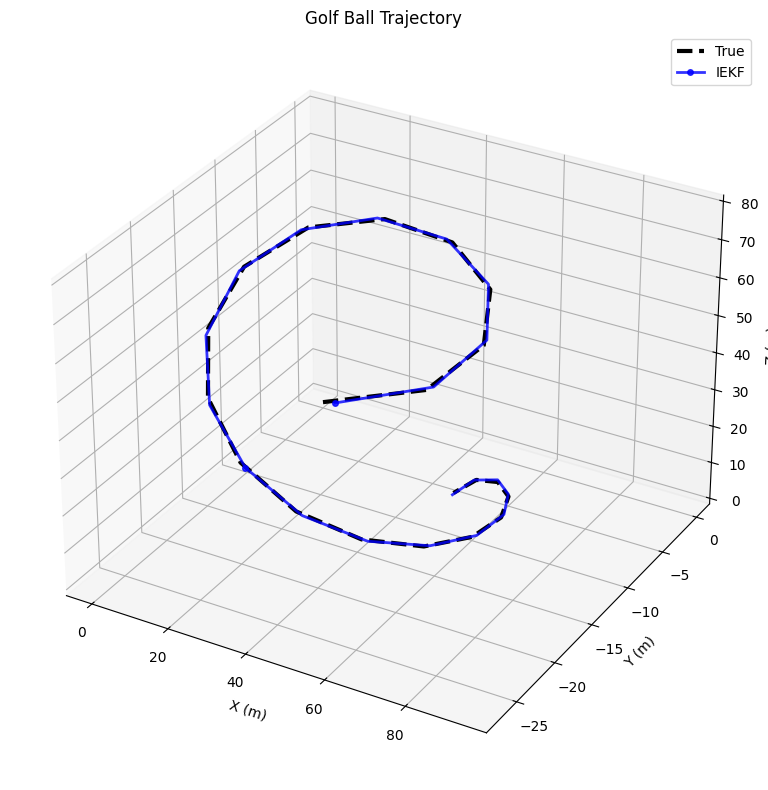

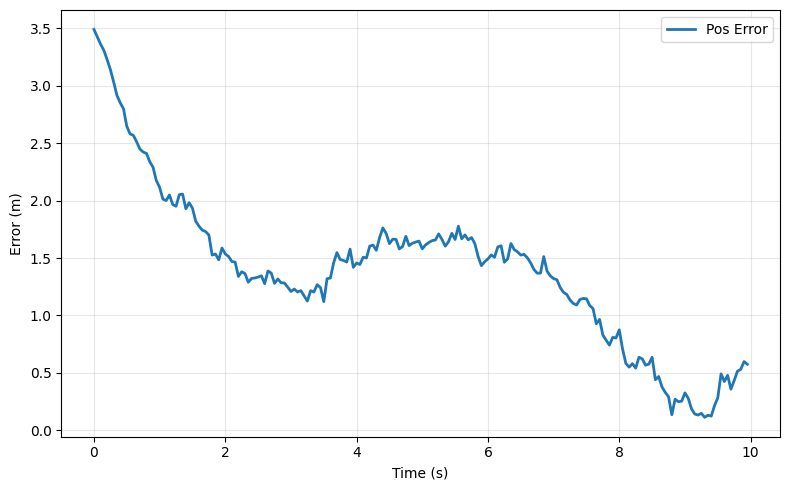

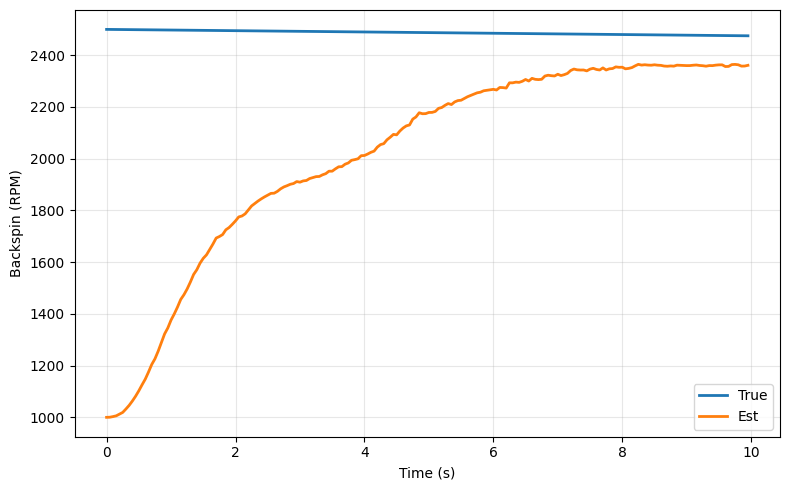

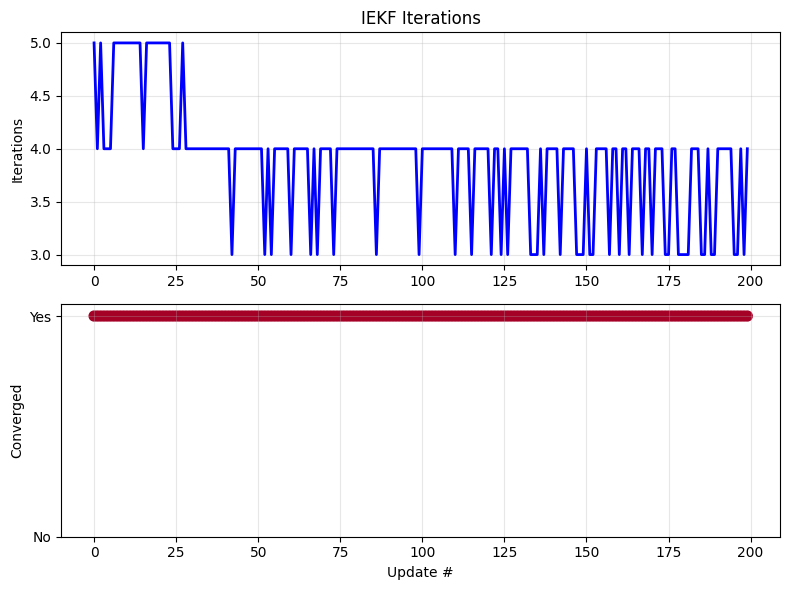

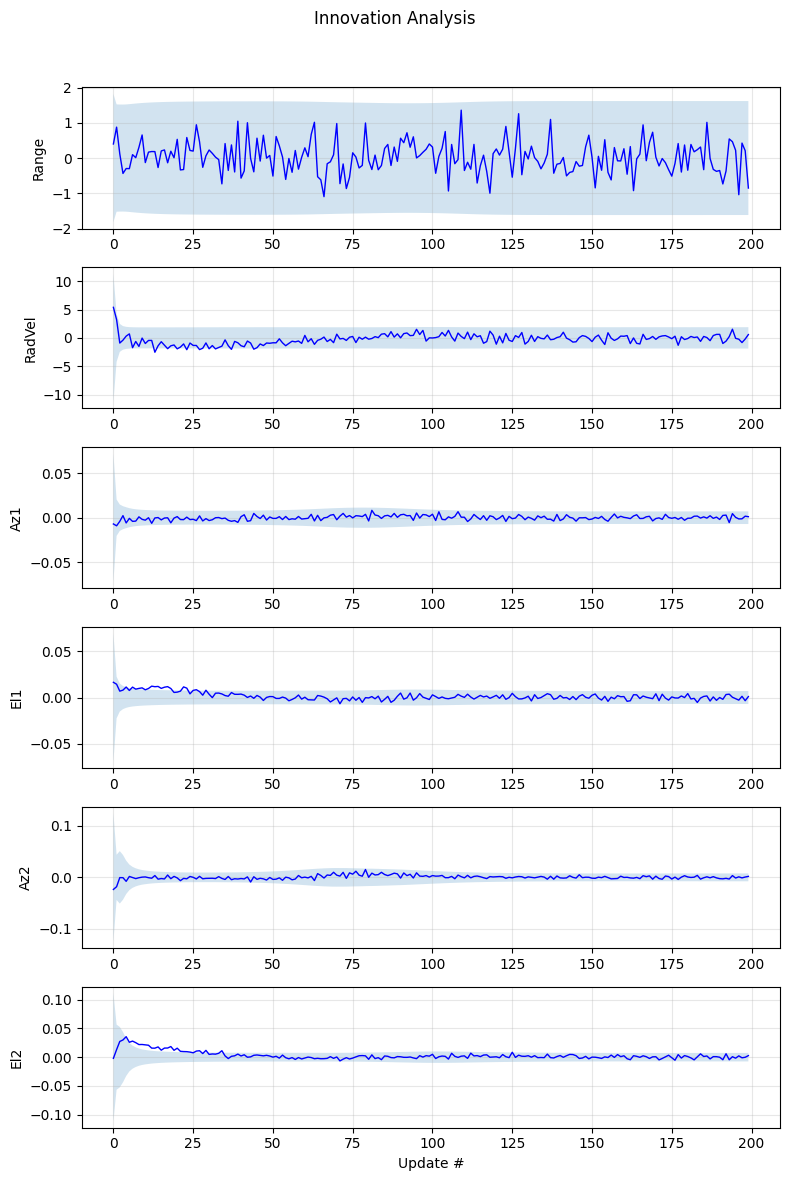

In [12]:
def main() -> None:
    np.random.seed(42)
    demo = BallTrackingDemo(
        physics=GolfBallPhysics(dt=0.01),
        sensors=GolfSensorSystem(),
        initial_speed=70,
        launch_angle=12,
        backspin_rpm=2500,
        sidespin_rpm=300,
        dt_meas=0.05,
    )
    demo.run()


if __name__ == "__main__":
    main()